In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pywt
import torch 
import scipy
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from hurst import compute_Hc, random_walk

In [2]:
temp_data = pd.read_csv('../Data/gsod_station_722860.csv')
temp_data = temp_data.iloc[:, 1:]
# Convert the 'date' column to datetime
temp_data['date'] = pd.to_datetime(temp_data['date'])
temp_data

,date,temp,max,min
0,1933-01-01,13.67,18.89,2.78
1,1933-01-02,13.89,19.61,1.89
2,1933-01-03,10.83,16.28,0.78
3,1933-01-04,14.94,21.28,1.28
4,1933-01-05,18.11,23.50,6.89
...,...,...,...,...
33646,2025-03-27,13.56,18.89,11.50
33647,2025-03-28,13.00,14.22,12.00
33648,2025-03-29,13.22,19.72,6.61
33649,2025-03-30,12.61,18.89,6.61


We skip the data analysis that is done in Main.ipynb

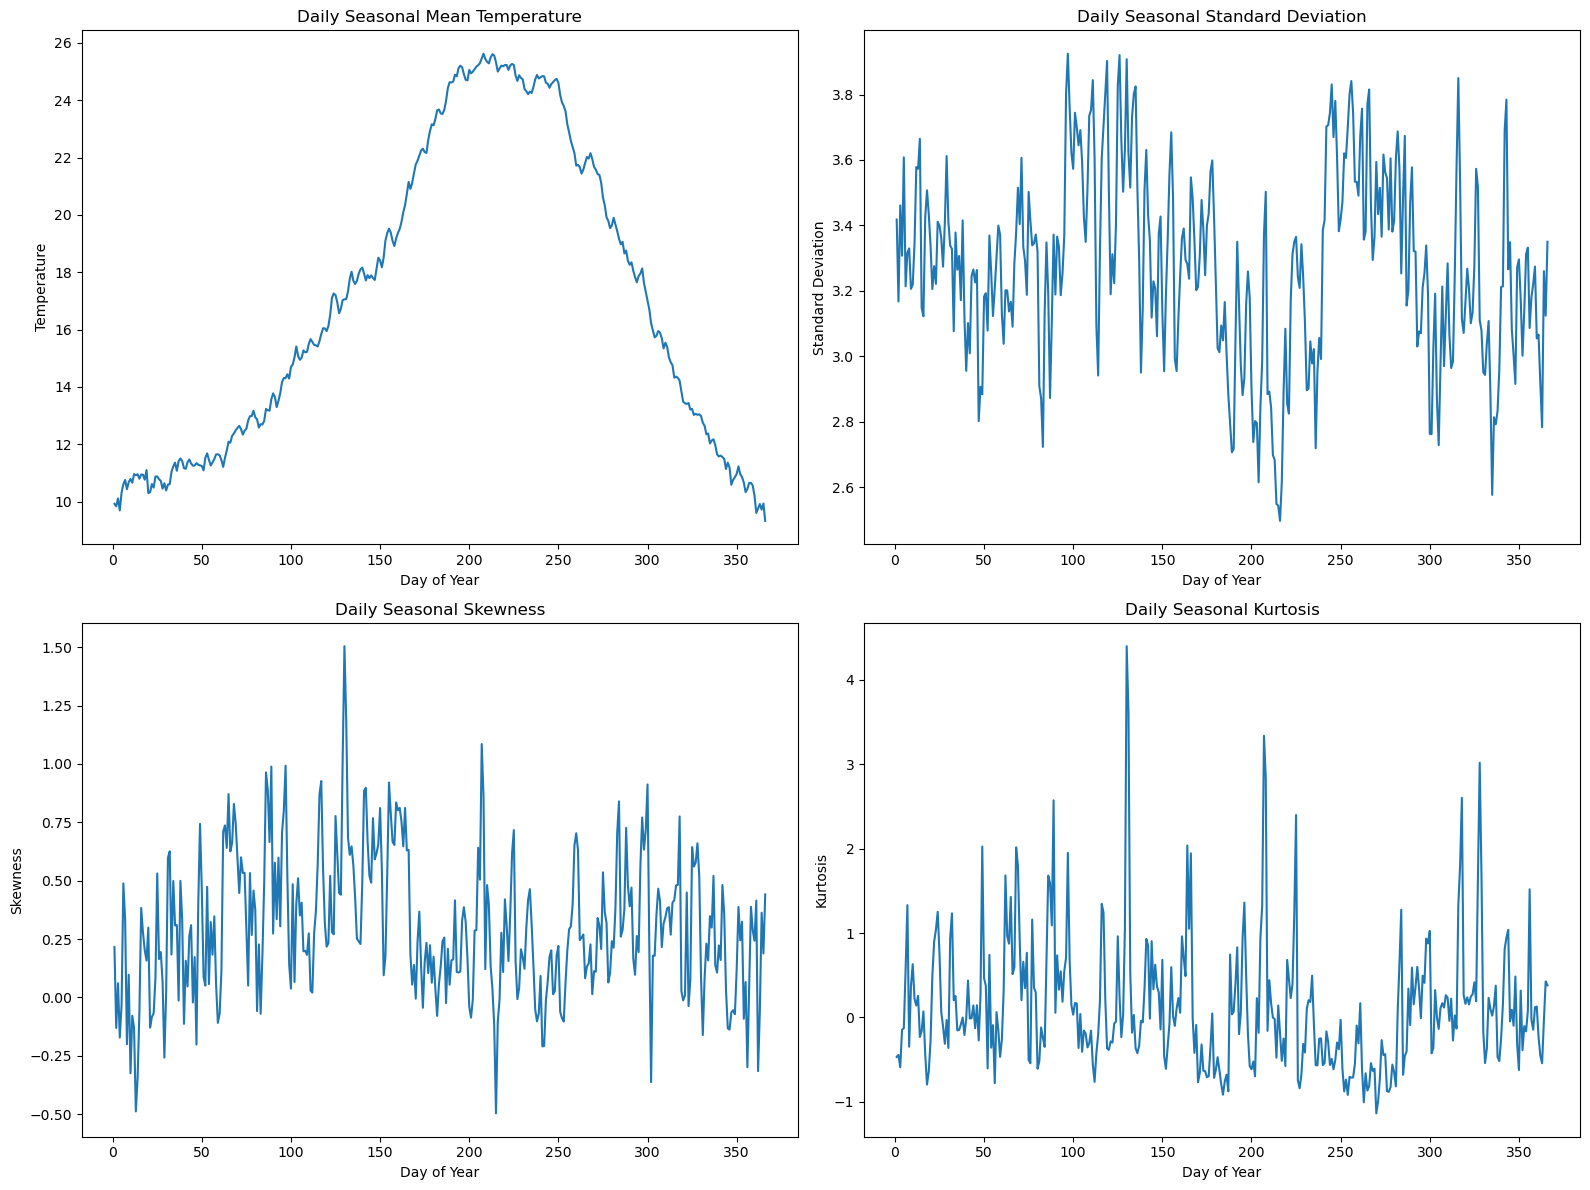

In [3]:
daily_seasonal_mean = temp_data.groupby(temp_data['date'].dt.dayofyear)['temp'].mean()
daily_seasonal_std = temp_data.groupby(temp_data['date'].dt.dayofyear)['temp'].std()
daily_seasonal_skew = temp_data.groupby(temp_data['date'].dt.dayofyear)['temp'].skew()
daily_seasonal_kurtosis = temp_data.groupby(temp_data['date'].dt.dayofyear)['temp'].apply(scipy.stats.kurtosis)

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
daily_seasonal_mean.plot(title='Daily Seasonal Mean Temperature')
plt.xlabel('Day of Year')
plt.ylabel('Temperature')

plt.subplot(2, 2, 2)
daily_seasonal_std.plot(title='Daily Seasonal Standard Deviation')
plt.xlabel('Day of Year')
plt.ylabel('Standard Deviation')

plt.subplot(2, 2, 3)
daily_seasonal_skew.plot(title='Daily Seasonal Skewness')
plt.xlabel('Day of Year')
plt.ylabel('Skewness')

plt.subplot(2, 2, 4)
daily_seasonal_kurtosis.plot(title='Daily Seasonal Kurtosis')
plt.xlabel('Day of Year')
plt.ylabel('Kurtosis')

plt.tight_layout()
plt.show()

# Detrend and deseasonalize (linear)
- Perform ADF and KPSS tests on the raw temperature data.
- Deseasonalize the temperature data by subtracting the daily seasonal mean.
- Perform ADF and KPSS tests on the deseasonalized temperature data.
- Detrend the time series using an OLS regression.
- Deseasonalize and whiten the detrended series.
- Perform ADF and KPSS tests on the deseasonalized and detrended series.
- Estimate the Hurst exponent of the original and processed series.
- Plot the ACF and PACF of the processed series.
      

In [4]:
# Function to perform the ADF test
def adf_test(series, title=''):
    print(f'ADF Test for {title}')
    result = adfuller(series.dropna())
    
    print('ADF Statistic: {:.4f}'.format(result[0]))
    print('p-value: {:.4f}'.format(result[1]))
    
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}'.format(key, value))
    
    if result[1] <= 0.05:
        print("=> Reject the null hypothesis (H0). The data is stationary.")
    else:
        print("=> Failed to reject the null hypothesis (H0). The data is non-stationary.")
    print("\n")

# Function to perform the KPSS test
def kpss_test(series, title=''):
    print(f'KPSS Test for {title}')
    result = kpss(series.dropna())
    
    print('KPSS Statistic: {:.4f}'.format(result[0]))
    print('p-value: {:.4f}'.format(result[1]))
    
    print('Critical Values:')
    for key, value in result[3].items():
        print('\t{}: {:.4f}'.format(key, value))
    
    if result[1] <= 0.05:
        print("=> Reject the null hypothesis (H0). The data is non-stationary.")
    else:
        print("=> Failed to reject the null hypothesis (H0). The data is stationary.")
    print("\n")

# Perform tests on raw temperature data
adf_test(temp_data['temp'], "Raw Temperature Data")
kpss_test(temp_data['temp'], "Raw Temperature Data")



ADF Test for Raw Temperature Data
ADF Statistic: -14.8124
p-value: 0.0000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
=> Reject the null hypothesis (H0). The data is stationary.


KPSS Test for Raw Temperature Data
KPSS Statistic: 0.1395
p-value: 0.1000
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
=> Failed to reject the null hypothesis (H0). The data is stationary.




/var/folders/yt/tw36rldj4vj59zcpt_d9sjww0000gn/T/ipykernel_15123/1355883317.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna())


# WA seasonal mean removal

first we need to prep the data further, removing feb 29 and adding an index 

In [5]:
df = temp_data.copy()

# Remove February 29 to have a consistent 365-day calendar
df['day_of_year'] = df['date'].dt.dayofyear
df = df[~((df['date'].dt.month == 2) & (df['date'].dt.day == 29))]

# Reset index and add t = 1, 2, ..., N
df = df.reset_index(drop=True)
df['t'] = df.index + 1


we estimate and remove the trend: 
We estimate and remove the trend using a linear regression model defined as:

$$\text{Trend}(t) = a + b \cdot t$$

where:
- $a$ is the intercept parameter
- $b$ is the slope parameter (rate of change over time)
- $t$ is the time index (1, 2, ..., n)

This linear trend is estimated using ordinary least squares (OLS) regression and then subtracted from the original temperature series to obtain the detrended data.


Slope: 0.00002
Intercept: 16.71339
t-statistic: 4.85024
p-value: 0.00000


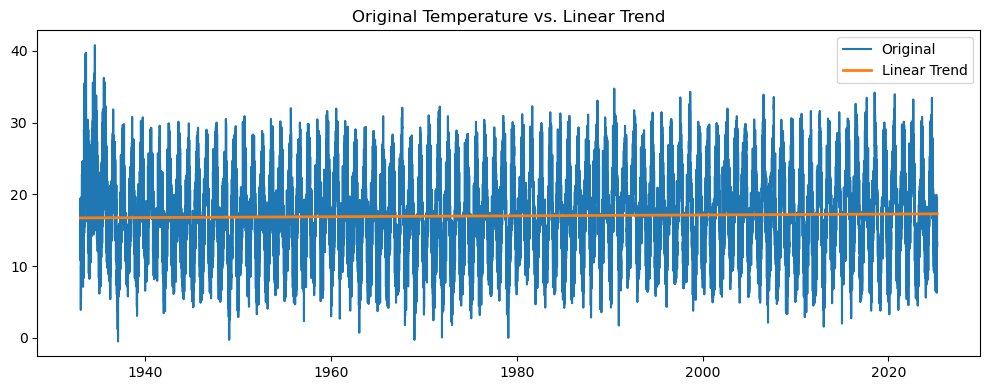

In [6]:
from scipy.stats import linregress

# Extract t and temperature
t = df['t'].values
temp = df['temp'].values

# Fit linear trend and obtain detailed statistics
result = linregress(t, temp)
slope, intercept, r_value, p_value, std_err = result
trend = intercept + slope * t

# Compute t-statistic manually (optional, since p-value is already given by linregress)
t_statistic = slope / std_err

# Print results
print(f"Slope: {slope:.5f}")
print(f"Intercept: {intercept:.5f}")
print(f"t-statistic: {t_statistic:.5f}")
print(f"p-value: {p_value:.5f}")

# Add trend and detrended series to DataFrame
df['trend'] = trend
df['detrended_temp'] = df['temp'] - df['trend']

# Plot to visualize trend
plt.figure(figsize=(10, 4))
plt.plot(df['date'], df['temp'], label='Original')
plt.plot(df['date'], df['trend'], label='Linear Trend', linewidth=2)
plt.title('Original Temperature vs. Linear Trend')
plt.legend()
plt.tight_layout()
plt.show()

now we decompose the detrended temperature using the Daubechies 11 wavelet

In [7]:

from WA_seasonal_mean import wavelet_decompose

coeff_dict = wavelet_decompose(df['detrended_temp'], wavelet_name='db11')

# Inspect
for key, value in coeff_dict.items():
    print(f"{key}: shape = {value.shape}")


approx: shape = (53,)
detail_1: shape = (16824,)
detail_2: shape = (8422,)
detail_3: shape = (4221,)
detail_4: shape = (2121,)
detail_5: shape = (1071,)
detail_6: shape = (546,)
detail_7: shape = (283,)
detail_8: shape = (152,)
detail_9: shape = (86,)
detail_10: shape = (53,)


<Figure size 1500x1000 with 0 Axes>

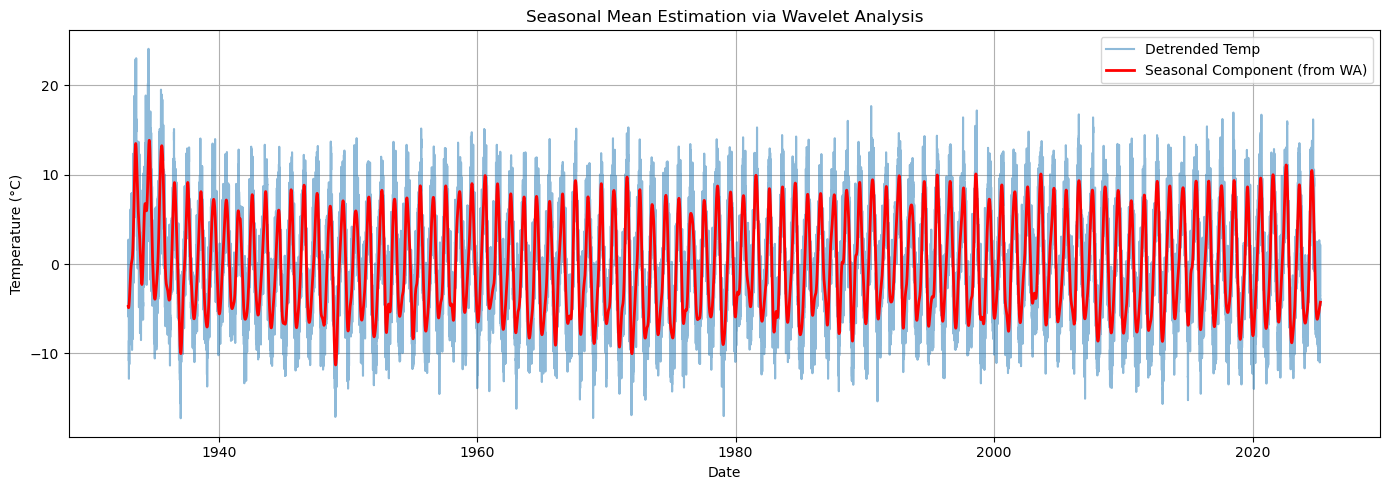

In [11]:
from WA_seasonal_mean import wavelet_reconstruct

keep = ['approx',  'detail_11', 'detail_10', 'detail_9', 'detail_8', 'detail_7']   
# Reconstruct seasonal component
seasonal_component = wavelet_reconstruct(coeff_dict, keep, wavelet_name='db11')
# Add this code to visualize each wavelet detail level separately
plt.figure(figsize=(15, 10))

# Add to DataFrame
df['seasonal'] = seasonal_component[:len(df)]  # match original length in case of rounding

# Plot to visualize seasonal component
plt.figure(figsize=(14, 5))

plt.plot(df['date'], df['detrended_temp'], label='Detrended Temp', alpha=0.5)
plt.plot(df['date'], df['seasonal'], label='Seasonal Component (from WA)', color='red', linewidth=2)

plt.title('Seasonal Mean Estimation via Wavelet Analysis')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

let's have a clearer idea by plotting just last 5 years

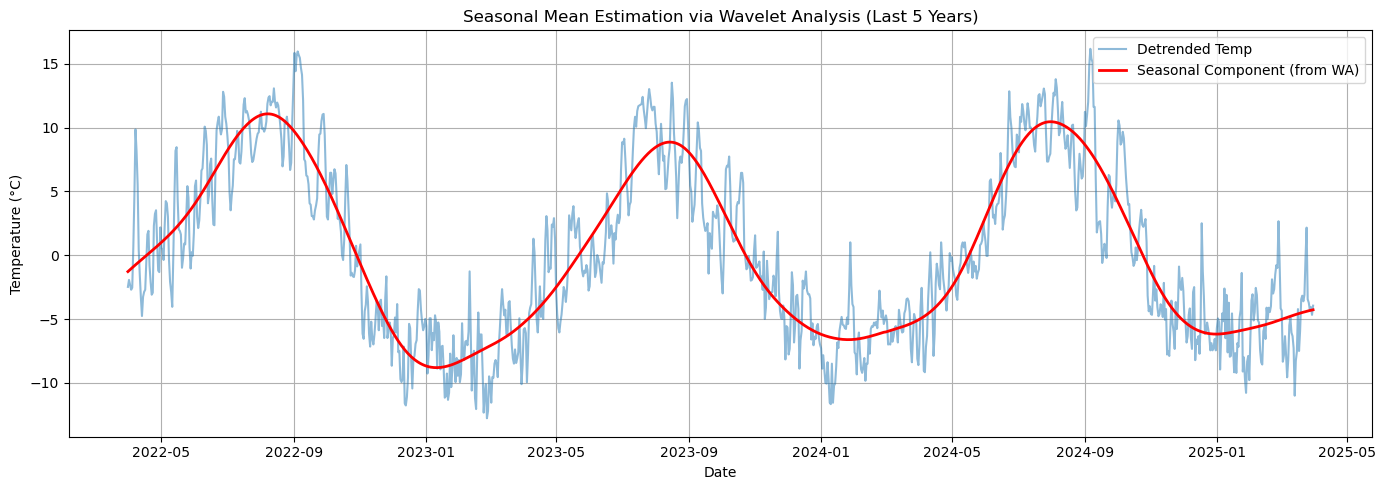

In [12]:
# Define the last 5-year window
end_date = df['date'].max()
start_date = end_date - pd.DateOffset(years=3)

# Filter the DataFrame
df_last5 = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Plot to visualize seasonal component for the last 5 years
plt.figure(figsize=(14, 5))

plt.plot(df_last5['date'], df_last5['detrended_temp'], label='Detrended Temp', alpha=0.5)
plt.plot(df_last5['date'], df_last5['seasonal'], label='Seasonal Component (from WA)', color='red', linewidth=2)

plt.title('Seasonal Mean Estimation via Wavelet Analysis (Last 5 Years)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

let's compute the sinusoid

$$\mathcal{S}(t) = \sum_{i=1}^{n} a_i \cdot \sin\left( \frac{2\pi (t - \phi_i)}{p_i} \right)$$

Where:
*   $t$ is the day index
*   $a_i$: amplitude (to be fitted)
*   $\phi_i$: phase shift (to be fitted)
*   $p_i$: period in days (fixed from wavelet inspection)

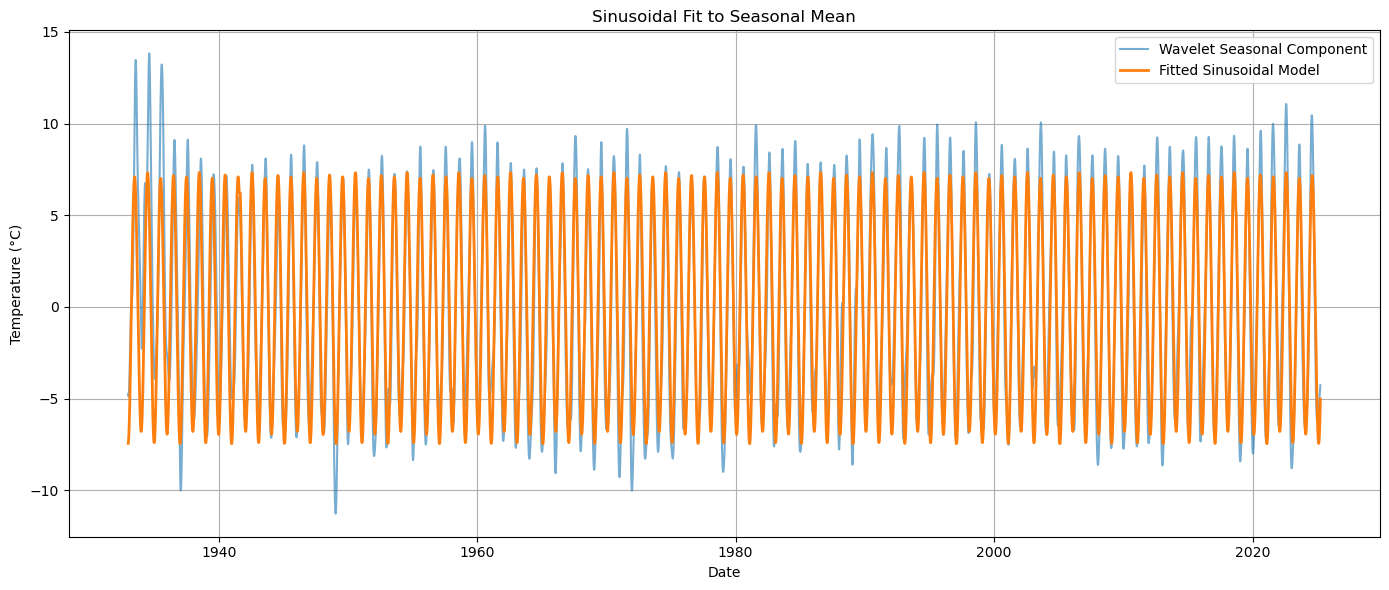

Cycle 1: Amplitude = 7.163, Phase Shift = 87.21, Period = 365 days
Cycle 2: Amplitude = 0.296, Phase Shift = 220.28, Period = 730 days
Cycle 3: Amplitude = 0.082, Phase Shift = 65.86, Period = 1460 days


In [13]:

from scipy.optimize import curve_fit

# Step 1: Define the periods corresponding to detail_3, 4, 5
# You can fine-tune these later based on analysis or trial-error
periods = [365, 730, 1460]  # approx: 1 year, 2 years, 4 years

# Step 2: Define the sinusoidal model with these 3 fixed periods
def seasonal_model(t, a1, phi1, a2, phi2, a3, phi3, a4, phi4):
    p1, p2, p3 = 365, 730, 1460
    p4 = 2920  # ~8 years (modulation period)

    modulated = a4 * (1 + np.sin(2 * np.pi * (t - phi4) / p4)) * np.sin(2 * np.pi * t / 365)

    return (
        a1 * np.sin(2 * np.pi * (t - phi1) / p1) +
        a2 * np.sin(2 * np.pi * (t - phi2) / p2) +
        a3 * np.sin(2 * np.pi * (t - phi3) / p3) +
        modulated
    )

# Step 3: Prepare the data for fitting
t = df['t'].values
y = df['seasonal'].values

# Initial guesses for [a1, phi1, a2, phi2, a3, phi3]
initial_guess = [10, 100, 5, 200, 2, 300, 2, 400]
# Step 4: Fit the sinusoidal model
popt, pcov = curve_fit(seasonal_model, t, y, p0=initial_guess)

# Generate fitted seasonal values
df['fitted_seasonal'] = seasonal_model(t, *popt)

# Step 5: Plot the result
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['seasonal'], label='Wavelet Seasonal Component', alpha=0.6)
plt.plot(df['date'], df['fitted_seasonal'], label='Fitted Sinusoidal Model', linewidth=2)
plt.title("Sinusoidal Fit to Seasonal Mean")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 6: Print the fitted parameters
for i in range(3):
    amp = popt[2*i]
    phase = popt[2*i + 1]
    print(f"Cycle {i+1}: Amplitude = {amp:.3f}, Phase Shift = {phase:.2f}, Period = {periods[i]} days")

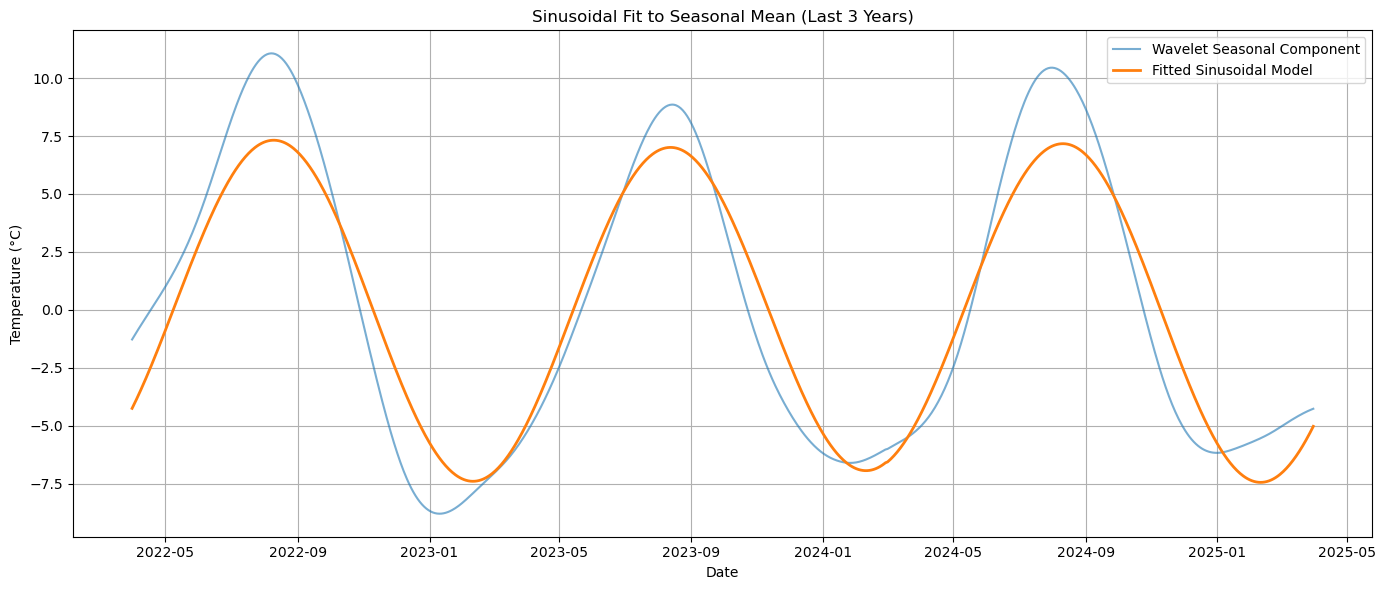

In [14]:
# Plot the last 3 years window
# Calculate the date 3 years before the last date
last_date = df['date'].max()
three_years_ago = last_date - pd.DateOffset(years=3)

# Filter the DataFrame
df_last_3years = df[df['date'] >= three_years_ago]

# Create the plot
plt.figure(figsize=(14, 6))
plt.plot(df_last_3years['date'], df_last_3years['seasonal'], label='Wavelet Seasonal Component', alpha=0.6)
plt.plot(df_last_3years['date'], df_last_3years['fitted_seasonal'], label='Fitted Sinusoidal Model', linewidth=2)
plt.title("Sinusoidal Fit to Seasonal Mean (Last 3 Years)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
df['residual'] = df['detrended_temp'] - df['fitted_seasonal']

# STOPPED HERE

In [ ]:
from hurst import compute_Hc

# Unit root tests on the deseasonalized and detrended series
adf_test(deseasonalized_detrended, "Deseasonalized and Detrended Temperature Data")
kpss_test(deseasonalized_detrended, "Deseasonalized and Detrended Temperature Data")

# Hurst exponent estimation
H, c, val = compute_Hc(temp_data['temp'], kind='change', simplified=True)
print(f"Hurst exponent of original series: {H:.4f}")

H_processed, c_processed, val_processed = compute_Hc(deseasonalized_detrended.dropna(), kind='change', simplified=True)
print(f"Hurst exponent of processed series: {H_processed:.4f}")

# Autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(deseasonalized_detrended.dropna(), lags=50, ax=plt.gca())
plt.title('ACF of Deseasonalized and Detrended Temperature Data')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(deseasonalized_detrended.dropna(), lags=50, ax=plt.gca())
plt.title('PACF of Deseasonalized and Detrended Temperature Data')
plt.show()

# Optional: Visualize the original vs. detrended vs. fully processed data
plt.figure(figsize=(14, 8))
plt.plot(temp_data['date'], temp_data['temp'], label='Original Temperature')
plt.plot(temp_data['date'], detrended, label='Detrended Temperature')
plt.plot(temp_data_with_day['date'], deseasonalized_detrended, label='Detrended & Deseasonalized')
plt.title('Temperature Data Processing Comparison')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'deseasonalized_detrended' is not defined

# estimating the mean reversion speed

In [18]:
from WA_mean_reversion_speed import estimate_mean_reversion
# Deseasonalize the data
deseasonalized = remove_seasonality(temp_data['temp'])

# Estimate mean reversion using Wavelet Network
results_wn = estimate_mean_reversion(
    temp_data_with_day['deseasonalized_detrended'], 
    dates=temp_data_with_day['date'], 
    max_lag=10,
    model_type='wavelet'
)

# Estimate mean reversion using MLP for comparison
results_mlp = estimate_mean_reversion(
    temp_data_with_day['deseasonalized_detrended'], 
    dates=temp_data_with_day['date'],
    max_lag=10,
    model_type='mlp'
)

# Compare the models
print("\nModel Comparison:")
print(f"Wavelet Network MSE: {results_wn['metrics']['mse']:.6f}, Mean k(t): {results_wn['metrics']['mean_k']:.6f}")
print(f"MLP MSE: {results_mlp['metrics']['mse']:.6f}, Mean k(t): {results_mlp['metrics']['mean_k']:.6f}")

ModuleNotFoundError: No module named 'sklearn'

# Volatility modeling

To model the variance, we work with squared residuals:

$$
Y(t) = \left( T(t) - S(t) \right)^2 = X(t)^2 \approx \sigma^2(t)

In [19]:
df['squared_residual'] = df['residual']**2

The volatility is also seasonal (e.g. winter more volatile than summer). So we do a wavelet decomposition of the squared residuals and reconstruct the seasonal part using appropriate detail levels. Essentialy we repeat what we did in the seasonal mean part

In [20]:
from WA_seasonal_mean import wavelet_decompose, wavelet_reconstruct

# Apply wavelet decomposition to squared residuals
vol_coeffs = wavelet_decompose(df['squared_residual'], wavelet_name='db11')

# Choose levels for volatility (usually same logic: detail_3–detail_5 or similar)
keep_vol = ['approx', 'detail_3', 'detail_4', 'detail_5']

# Reconstruct seasonal volatility
volatility_seasonal = wavelet_reconstruct(vol_coeffs, keep_vol, wavelet_name='db11')
df['seasonal_volatility'] = volatility_seasonal[:len(df)]

def volatility_model(t, a1, phi1):
    return a1 * (1 + np.sin(2 * np.pi * (t - phi1) / 365))


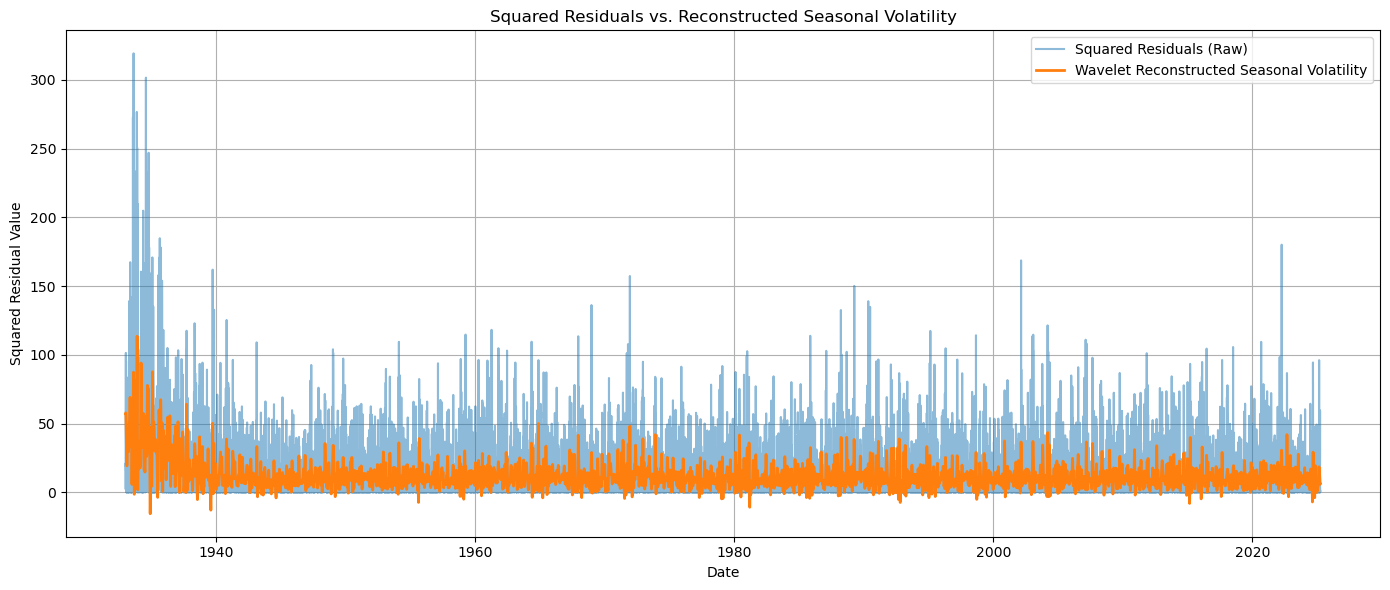

In [21]:
from WA_seasonal_mean import wavelet_decompose, wavelet_reconstruct

# ---------- Step 1: Wavelet Decomposition and Reconstruction of Squared Residuals ----------

# Decompose the squared residuals using wavelets (example with Daubechies 11)
vol_coeffs = wavelet_decompose(df['squared_residual'], wavelet_name='db11')

# Choose selected levels to capture the seasonal volatility structure.
# Here we choose the approximation plus details 3, 4, and 5.
keep_vol = ['approx', 'detail_5', 'detail_6', 'detail_7']

# Reconstruct the seasonal volatility component from these levels.
volatility_seasonal = wavelet_reconstruct(vol_coeffs, keep_vol, wavelet_name='db11')
df['seasonal_volatility'] = volatility_seasonal[:len(df)]  # Ensure matching length

# ---------- Step 2: Plot the Squared Residuals and the Reconstructed Seasonal Volatility ----------

plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['squared_residual'], label='Squared Residuals (Raw)', alpha=0.5)
plt.plot(df['date'], df['seasonal_volatility'], label='Wavelet Reconstructed Seasonal Volatility', linewidth=2)
plt.title("Squared Residuals vs. Reconstructed Seasonal Volatility")
plt.xlabel("Date")
plt.ylabel("Squared Residual Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


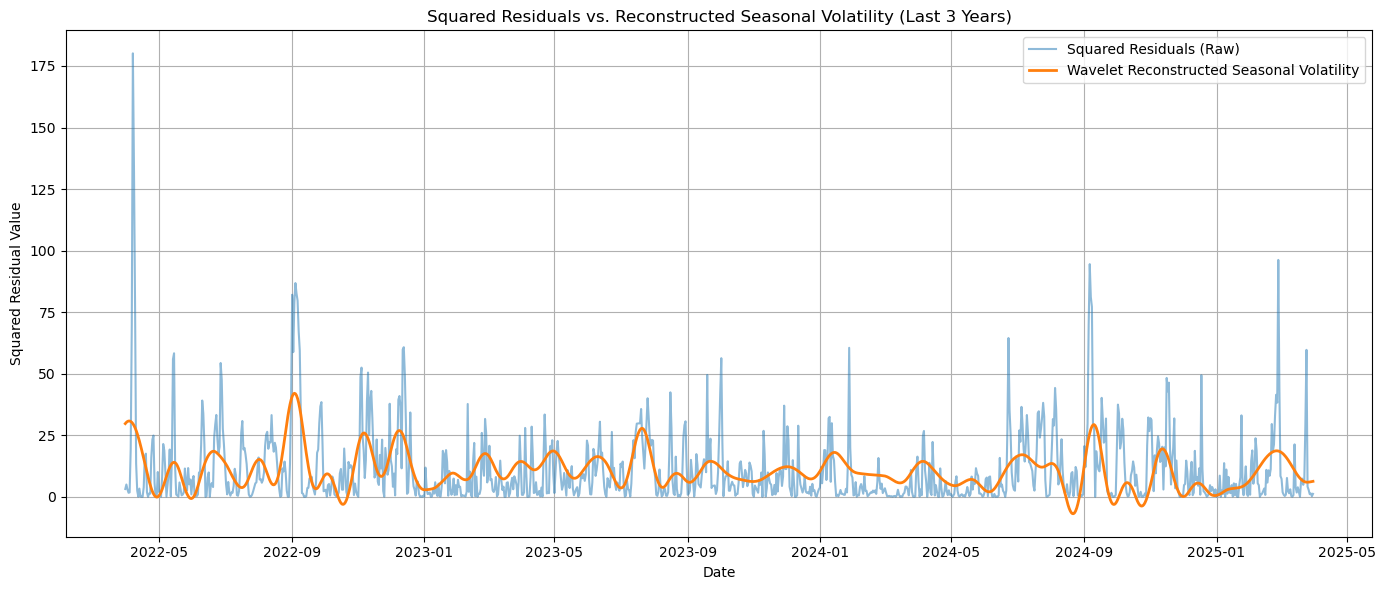

In [22]:
# Plot for the last 3 years
# Calculate the date range
last_date = df['date'].max()
three_years_ago = last_date - pd.DateOffset(years=3)

# Filter the DataFrame
df_last_3years = df[df['date'] >= three_years_ago]

# Create the plot
plt.figure(figsize=(14, 6))
plt.plot(df_last_3years['date'], df_last_3years['squared_residual'], 
         label='Squared Residuals (Raw)', alpha=0.5)
plt.plot(df_last_3years['date'], df_last_3years['seasonal_volatility'], 
         label='Wavelet Reconstructed Seasonal Volatility', linewidth=2)
plt.title("Squared Residuals vs. Reconstructed Seasonal Volatility (Last 3 Years)")
plt.xlabel("Date")
plt.ylabel("Squared Residual Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

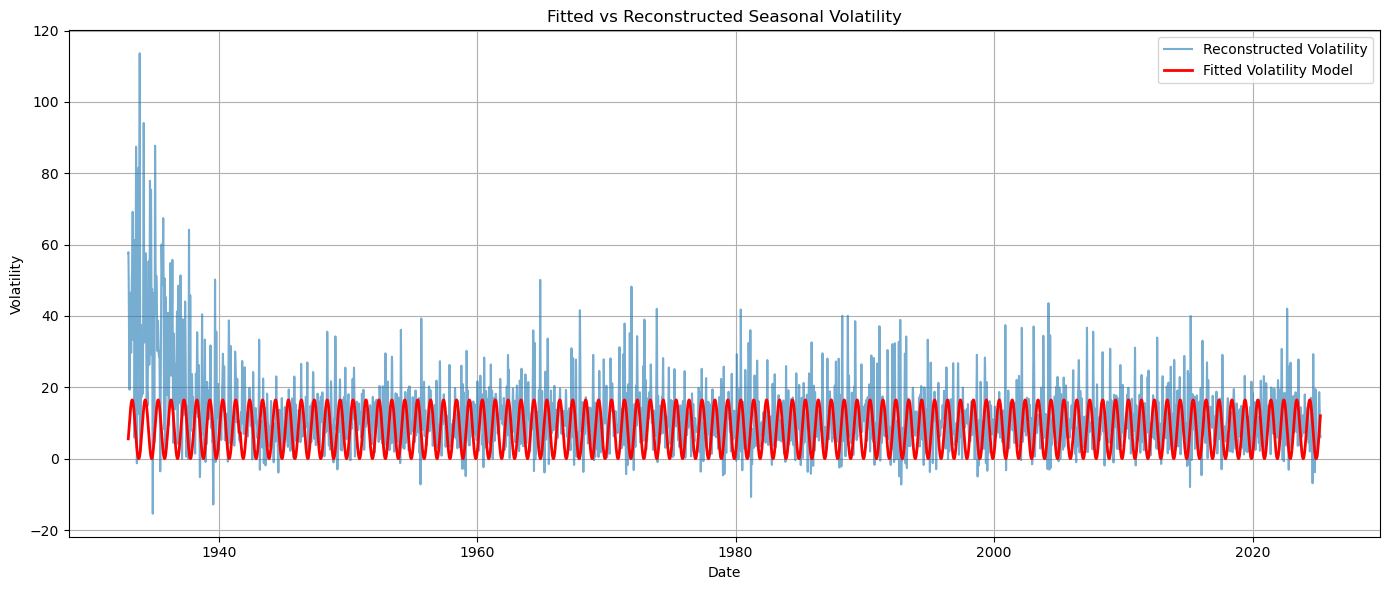

Fitted amplitude (a1): 8.2311
Fitted phase shift (phi1): 20.1689 days


In [28]:

# ---------- Step 3: Define the Sinusoidal Volatility Model ----------

def volatility_model(t, a1, phi1):
    # This model assumes annual periodicity for the volatility modulation.
    return a1 * (1 + np.sin(2 * np.pi * (t - phi1) / 365))

# ---------- Step 4: Fit the Sinusoidal Model to the Reconstructed Volatility ----------

# Prepare t and y for curve fitting.
t_values = df['t'].values
y_vol = df['seasonal_volatility'].values

# Set initial guesses; a1 is roughly the mean level of volatility, phi1 is a phase shift guess.
initial_guess_vol = [np.mean(y_vol), 180]

# Use curve_fit to fit the model.
popt_vol, pcov_vol = curve_fit(volatility_model, t_values, y_vol, p0=initial_guess_vol,  bounds=([0, 0], [np.inf, 365]), maxfev=10000)

# Calculate the fitted values from the model.
fitted_volatility = volatility_model(t_values, *popt_vol)
df['fitted_volatility'] = fitted_volatility

# ---------- Step 5: Plot the Fitted Volatility Model vs. the Reconstructed Volatility ----------

plt.figure(figsize=(14, 6))
plt.plot(df['date'], y_vol, label='Reconstructed Volatility', alpha=0.6)
plt.plot(df['date'], fitted_volatility, label='Fitted Volatility Model', linewidth=2, color='red')
plt.title("Fitted vs Reconstructed Seasonal Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the fitted parameters
print(f"Fitted amplitude (a1): {popt_vol[0]:.4f}")
print(f"Fitted phase shift (phi1): {popt_vol[1]:.4f} days")



In [29]:
# ---------- Step 6: Print the Fitted Parameters ----------

a1, phi1 = popt_vol
print(f"Fitted parameter a1 (amplitude): {a1:.3f}")
print(f"Fitted parameter phi1 (phase shift): {phi1:.2f} days")

Fitted parameter a1 (amplitude): 8.231
Fitted parameter phi1 (phase shift): 20.17 days
